Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 164MB/s]


Epoch 1/10: Train Acc=0.8059, Val Acc=0.9584
Epoch 2/10: Train Acc=0.9561, Val Acc=0.9676
Epoch 3/10: Train Acc=0.9807, Val Acc=0.9569
Epoch 4/10: Train Acc=0.9807, Val Acc=0.9599
Epoch 5/10: Train Acc=0.9800, Val Acc=0.9661
Epoch 6/10: Train Acc=0.9911, Val Acc=0.9723
Epoch 7/10: Train Acc=0.9950, Val Acc=0.9800
Epoch 8/10: Train Acc=0.9911, Val Acc=0.9723
Epoch 9/10: Train Acc=0.9881, Val Acc=0.9507
Epoch 10/10: Train Acc=0.9900, Val Acc=0.9676


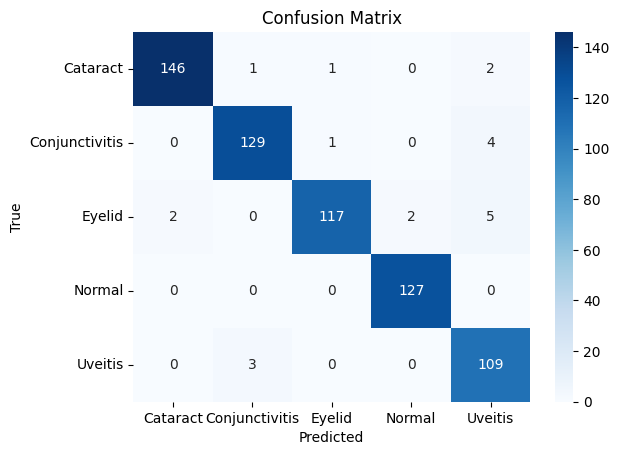


Classification Report:
                precision    recall  f1-score   support

      Cataract       0.99      0.97      0.98       150
Conjunctivitis       0.97      0.96      0.97       134
        Eyelid       0.98      0.93      0.96       126
        Normal       0.98      1.00      0.99       127
       Uveitis       0.91      0.97      0.94       112

      accuracy                           0.97       649
     macro avg       0.97      0.97      0.97       649
  weighted avg       0.97      0.97      0.97       649



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


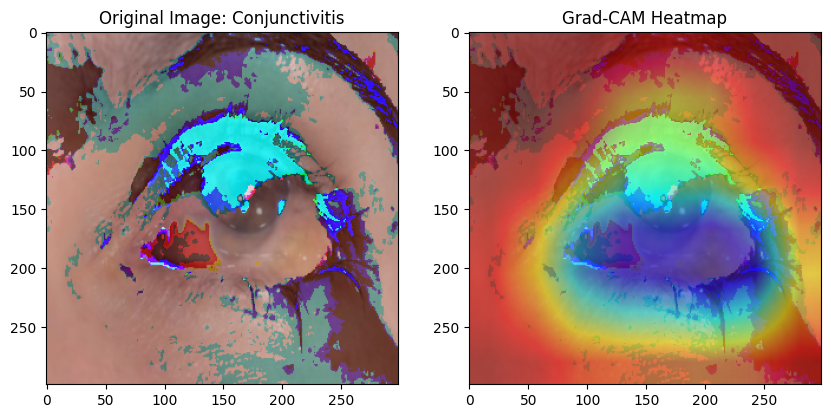

In [2]:
# Step 1: Import Libraries and Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision.models import Inception_V3_Weights

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Define Paths and Classes
dataset_path = "/content/drive/MyDrive/Eye Paper/data"
classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']

# Step 3: Dataset Preparation
data, labels = [], []
for cls_id, cls_name in enumerate(classes):
    folder = os.path.join(dataset_path, cls_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (299, 299))  # Resize to 299x299 for Inception-v3
        data.append(img)
        labels.append(cls_id)

data = np.array(data)
labels = np.array(labels)

# Flatten and Balance Data Using SMOTE
data_flat = data.reshape(len(data), -1)
smote = SMOTE(random_state=42)
data_balanced, labels_balanced = smote.fit_resample(data_flat, labels)
data_balanced = data_balanced.reshape(-1, 299, 299, 3)

# Split Dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    data_balanced, labels_balanced, test_size=0.2, random_state=42)

# Define Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class EyeDiseaseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).permute(2, 0, 1) / 255.0
        return img.float(), label

train_dataset = EyeDiseaseDataset(train_data, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 4: Define Inception-v3 Model
model_inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
model_inception.fc = nn.Linear(model_inception.fc.in_features, len(classes))
model_inception.AuxLogits.fc = nn.Linear(model_inception.AuxLogits.fc.in_features, len(classes))
model_inception = model_inception.to(device)

# Step 5: Train the Model
def train_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(imgs)
            loss_main = criterion(outputs, labels)
            loss_aux = criterion(aux_outputs, labels)
            loss = loss_main + 0.4 * loss_aux  # Combine main and auxiliary losses
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model(model_inception, train_loader, test_loader, num_epochs=10)

# Step 6: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

evaluate_model(model_inception, test_loader)

# Step 7: Grad-CAM Visualization
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx, device):
        self.activations = self.activations.to(device)
        self.gradients = self.gradients.to(device)

        weights = torch.mean(self.gradients, dim=(2, 3))
        heatmap = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights[0]):
            heatmap += w * self.activations[0, i, :, :]
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
        heatmap = cv2.resize(heatmap, (299, 299))
        heatmap = heatmap / np.max(heatmap)
        return heatmap

    def __call__(self, input_img, target_class):
        input_img.requires_grad = True
        output = self.model(input_img)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()
        return self.generate_heatmap(class_idx=target_class, device=input_img.device)

grad_cam_inception = GradCam(model_inception, target_layer=model_inception.Mixed_7c)

# Visualize Grad-CAM
def visualize_gradcam(model, grad_cam, img, label, class_names):
    img_tensor = img.unsqueeze(0).to(device)
    heatmap = grad_cam(img_tensor, label)

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / overlay.max()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image: {class_names[label]}")
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(overlay)
    plt.show()

for img, label in test_loader:
    visualize_gradcam(model_inception, grad_cam_inception, img[0], label[0], classes)
    break